In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import euclidean_distances


In [42]:
data = pd.read_csv("data/ikea_kommun_data.txt", delimiter='\t', encoding='ISO-8859-1')
# Show first few rows
print(data.head())

   Kommun_code  Year     Kommun_name  Revenue  Employee  Population  \
0         2583  2010       Haparanda     1078       276       10059   
1          880  2010          Kalmar     3790      1621       62815   
2         1780  2010        Karlstad     4560      1910       85753   
3          114  2010  Upplands Väsby     1366       708       39289   
4          115  2010      Vallentuna      171        99       30114   

   Population_University  Percent_University  Productivity  SalesIndex  \
0                    719            0.071478     195.74174  111.075774   
1                   8716            0.138757     117.17365  390.516869   
2                  13308            0.155190     119.64794  469.856708   
3                   4419            0.112474      96.69215  140.750935   
4                   3843            0.127615      86.56347   17.619627   

   Infrast  Border  
0        0       1  
1        0       0  
2        0       0  
3        0       0  
4        0       0  


In [43]:
data.describe()

,Kommun_code,Year,Revenue,Employee,Population,Population_University,Percent_University,Productivity,SalesIndex,Infrast,Border
count,207.000000,207.0,207.000000,207.000000,207.000000,207.000000,207.000000,207.000000,207.000000,207.000000,207.000000
mean,1049.734300,2010.0,1031.801932,523.038647,34543.396135,4660.106280,0.097461,91.454002,106.315583,0.048309,0.038647
std,541.065455,0.0,2694.889549,1463.194427,66882.499740,14403.495784,0.040760,27.960867,277.678055,0.214939,0.193220
min,114.000000,2010.0,11.000000,2.000000,3672.000000,174.000000,0.046142,19.898880,1.133426,0.000000,0.000000
25%,582.500000,2010.0,110.000000,64.500000,10785.500000,788.500000,0.069015,74.700910,11.334263,0.000000,0.000000
50%,1263.000000,2010.0,252.000000,142.000000,16515.000000,1598.000000,0.086601,90.457050,25.965765,0.000000,0.000000
75%,1461.500000,2010.0,825.500000,435.000000,37922.000000,4073.500000,0.112085,104.008805,85.058489,0.000000,0.000000
max,2583.000000,2010.0,32897.000000,18795.000000,847073.000000,191585.000000,0.269646,275.636330,3389.665819,1.000000,1.000000


In [44]:
print(f"The number of rows:{data.shape[0]} The number of columns: {data.shape[1]}")
print(data.info())

The number of rows:207 The number of columns: 12
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207 entries, 0 to 206
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Kommun_code            207 non-null    int64  
 1   Year                   207 non-null    int64  
 2   Kommun_name            207 non-null    object 
 3   Revenue                207 non-null    int64  
 4   Employee               207 non-null    int64  
 5   Population             207 non-null    int64  
 6   Population_University  207 non-null    int64  
 7   Percent_University     207 non-null    float64
 8   Productivity           207 non-null    float64
 9   SalesIndex             207 non-null    float64
 10  Infrast                207 non-null    int64  
 11  Border                 207 non-null    int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 19.5+ KB
None


In [45]:
# Check for missing values
print(data.isnull().sum())


Kommun_code              0
Year                     0
Kommun_name              0
Revenue                  0
Employee                 0
Population               0
Population_University    0
Percent_University       0
Productivity             0
SalesIndex               0
Infrast                  0
Border                   0
dtype: int64


In [46]:
# Store 'Kommun_name' separately for later labeling
kommun_names = data['Kommun_name']
# Drop irrelevant columns (e.g., Year, Kommun_code)
data_clean = data.drop(['Year', 'Kommun_code','Kommun_name'], axis=1)

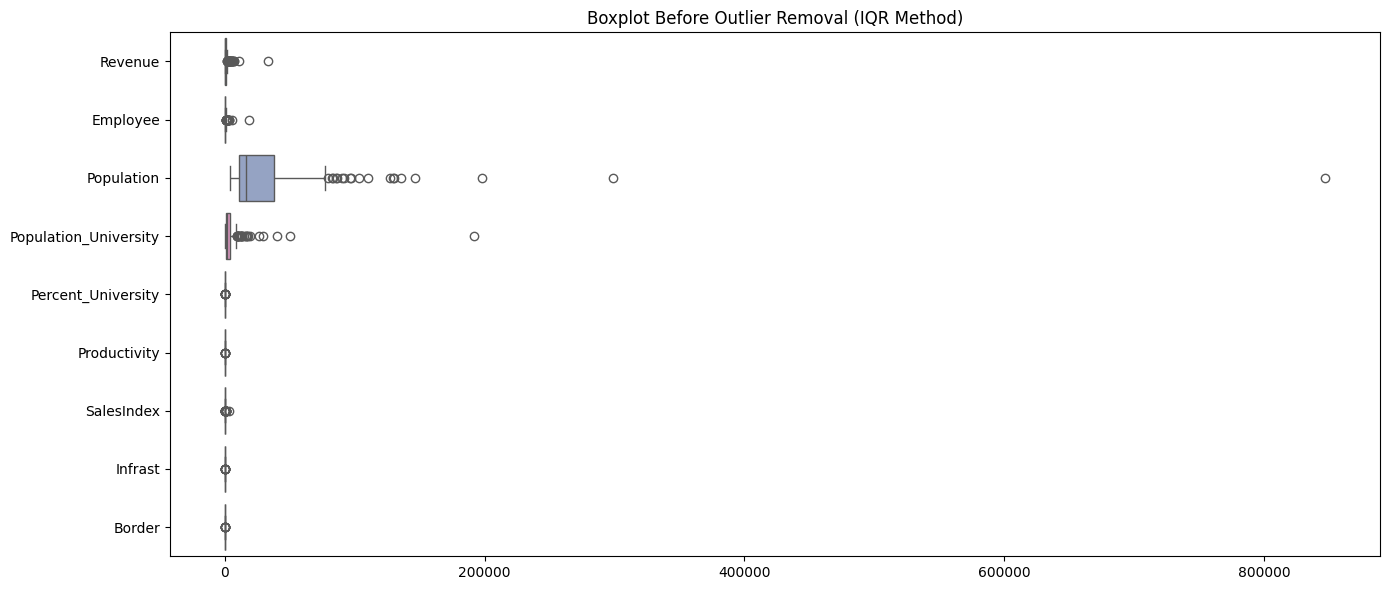

In [47]:
# --- BEFORE OUTLIER REMOVAL ---
plt.figure(figsize=(14, 6))
sns.boxplot(data=data_clean, orient="h", palette="Set2")
plt.title("Boxplot Before Outlier Removal (IQR Method)")
plt.tight_layout()
plt.show()

In [48]:
# Remove outliers using IQR method
Q1 = data_clean.quantile(0.25)
Q3 = data_clean.quantile(0.75)
IQR = Q3 - Q1

# Boolean mask for filtering
mask = ~((data_clean < (Q1 - 1.5 * IQR)) | (data_clean > (Q3 + 1.5 * IQR))).any(axis=1)

# Apply mask to both clean data and original data
data_clean = data_clean[mask]
data = data[mask]
kommun_names = kommun_names[mask]

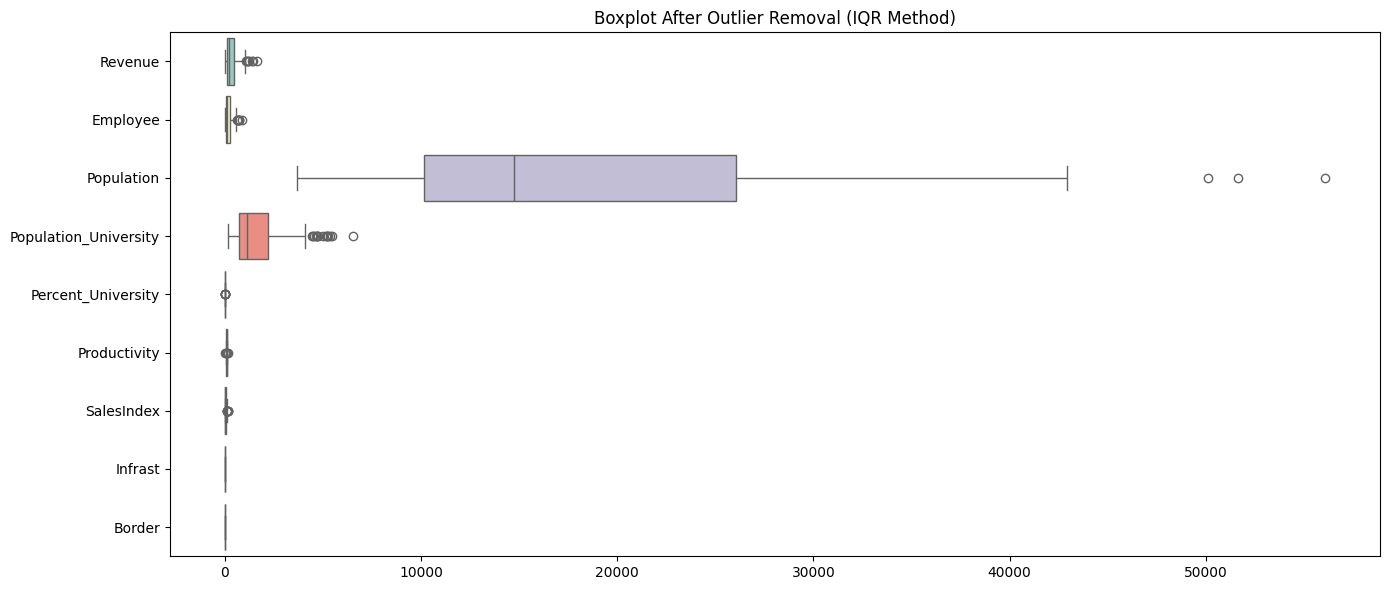

In [49]:

# --- AFTER OUTLIER REMOVAL ---
plt.figure(figsize=(14, 6))
sns.boxplot(data=data_clean, orient="h", palette="Set3")
plt.title("Boxplot After Outlier Removal (IQR Method)")
plt.tight_layout()
plt.show()

In [50]:

# Normalize the features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_clean)

In [51]:
# First I check explained variance instead of fixing components to 2 initially, 
pca = PCA()
pca.fit(data_scaled)
explained_var_ratio = np.cumsum(pca.explained_variance_ratio_)



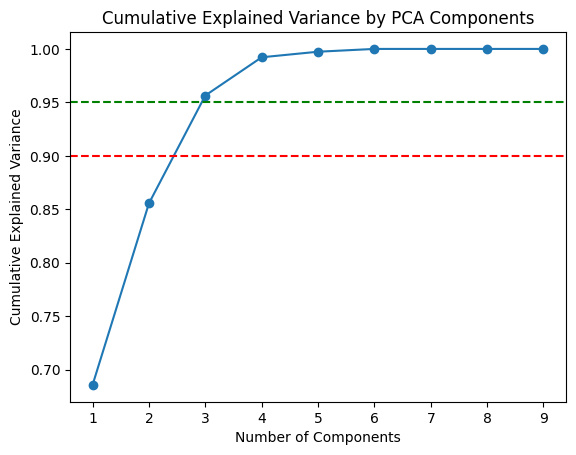

In [52]:
# I want to plot to see how many components explain 90-95%
plt.plot(range(1, len(explained_var_ratio)+1), explained_var_ratio, marker='o')
plt.axhline(y=0.90, color='r', linestyle='--')
plt.axhline(y=0.95, color='g', linestyle='--')
plt.title("Cumulative Explained Variance by PCA Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.show()

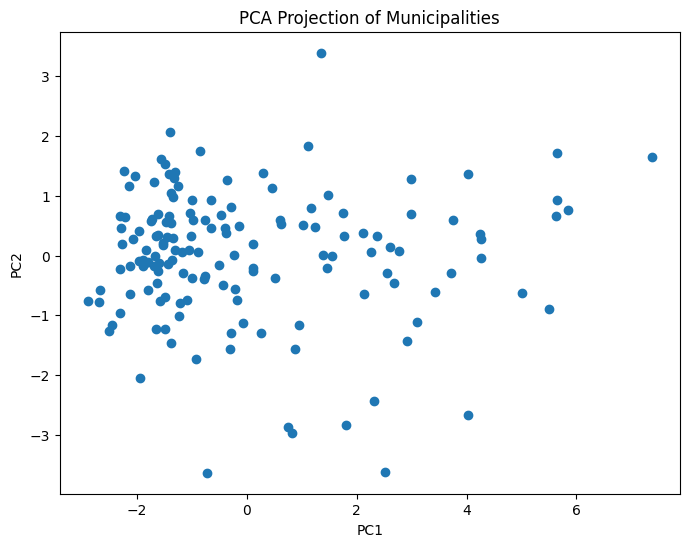

In [53]:
# Dimensionality Reduction with Principle component Analysis (PCA)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(data_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.title("PCA Projection of Municipalities")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

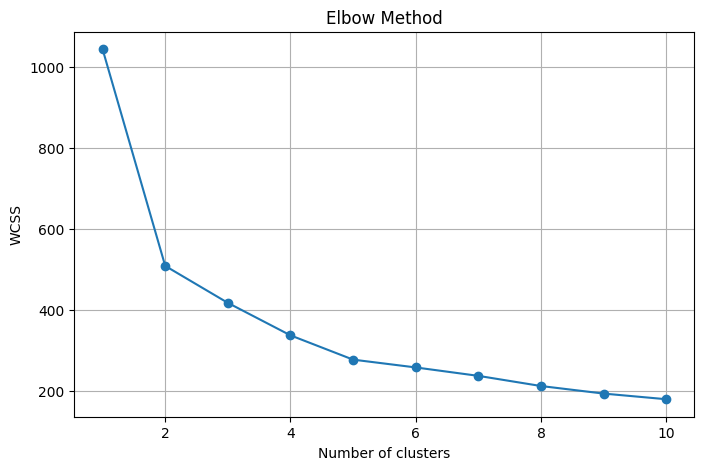

In [54]:
#Find Optimal Number of Clusters (Elbow Method)
wcss = []  # within-cluster sum of squares

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(data_scaled)
    wcss.append(kmeans.inertia_)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [55]:
# Try both k=2 and k=3
for k in [2, 3]:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(data_scaled)
    score = silhouette_score(data_scaled, labels)
    print(f"Silhouette Score for k={k}: {score:.2f}")

Silhouette Score for k=2: 0.50
Silhouette Score for k=3: 0.47


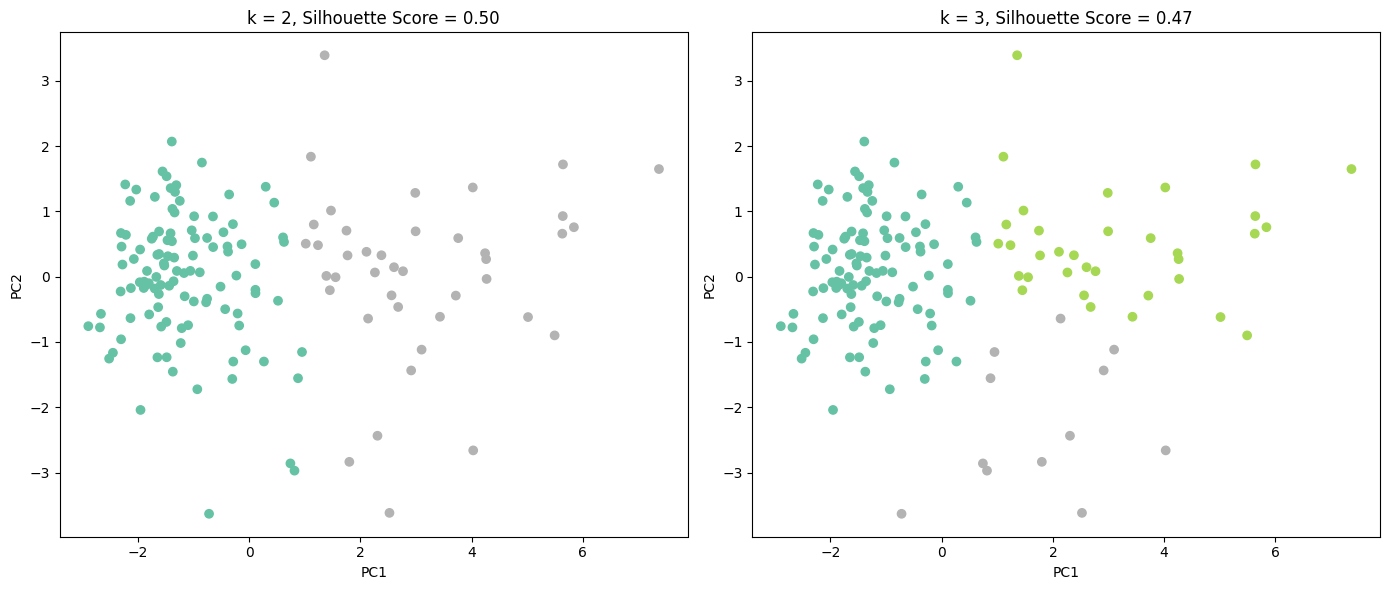

In [56]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

for ax, k in zip(axs, [2, 3]):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(data_scaled)
    ax.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='Set2')
    ax.set_title(f'k = {k}, Silhouette Score = {silhouette_score(data_scaled, labels):.2f}')
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")

plt.tight_layout()
plt.show()

 Based on both the elbow method and silhouette scores, k=2 provides the best clustering quality.
  Although k=3 also yielded a reasonable score (0.47), k=2 had a higher silhouette score (0.50),
  indicating more distinct and well-separated clusters.
Therefore, we proceed with k=2 as the optimal number of clusters.

In [57]:
# Let's  the elbow plot suggests k=2 
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(data_scaled)
# Add clusters to the PCA dataframe
data['Cluster'] = clusters

# Sample exploration
print(data.groupby("Cluster")[["Population", "SalesIndex", "Revenue"]].mean())

           Population  SalesIndex     Revenue
Cluster                                      
0        12858.638889   15.539770  150.814815
1        34345.829268   79.302142  769.634146


In [58]:
# Identify Municipalities With Existing IKEA Stores
existing_ikea = [
    "Borlänge", "Gävle", "Göteborg", "Haparanda", "Helsingborg", "Jönköping",
    "Kalmar", "Karlstad", "Linköping", "Malmö", "Stockholm", "Sundsvall",
    "Uddevalla", "Umeå", "Uppsala", "Västerås", "Älmhult", "Örebro"
]

# Add IKEA flag
data["Has_IKEA"] = data["Kommun_name"].isin(existing_ikea)



In [59]:
# Now we can suggest new locations
# IKEA clusters (clusters where IKEA already exists)
ikea_clusters = data[data["Has_IKEA"] == True]["Cluster"].unique()

# Filter cities in IKEA clusters that do NOT have IKEA
potential_city_clusters = data[(data["Cluster"].isin(ikea_clusters)) & (data["Has_IKEA"] == False)].copy()
print(potential_city_clusters[["Kommun_name", "Cluster"]])

        Kommun_name  Cluster
3    Upplands Väsby        1
5         Österåker        1
6            Värmdö        1
13           Tyresö        1
22       Sundbyberg        1
26        Norrtälje        1
27          Sigtuna        1
34         Enköping        1
38         Nyköping        1
41      Katrineholm        1
43        Strängnäs        1
55           Motala        1
57           Mjölby        1
62         Gislaved        1
65           Nässjö        1
66          Värnamo        1
68         Vetlanda        1
78          Ljungby        1
86       Oskarshamn        1
87        Västervik        1
99         Vellinge        1
103        Kävlinge        1
115          Åstorp        1
119      Landskrona        1
122           Eslöv        1
123           Ystad        1
127       Ängelholm        1
128      Hässleholm        1
135         Härryda        1
136        Partille        1
138     Stenungsund        1
147           Lerum        1
158            Mark        1
166         Ku

In [60]:
# 3 candidates for opening new IKEA stores, based on highest population


# Prepare distance column
potential_city_clusters["Centroid_Distance"] = np.nan

# For each IKEA cluster, find cities closest to centroid
for cluster_id in ikea_clusters:
    print(f"Processing Cluster {cluster_id}")
    
    # Get centroid
    cluster_centroid = kmeans.cluster_centers_[cluster_id]

    # Get cities in this cluster
    cluster_mask = (potential_city_clusters["Cluster"] == cluster_id)
    city_indices = potential_city_clusters[cluster_mask].index

    # Match those to original row numbers in scaled data
    scaled_positions = data.index.get_indexer(city_indices)

    # Compute distances from centroid
    cluster_scaled = data_scaled[scaled_positions]
    distances = euclidean_distances(cluster_scaled, [cluster_centroid])

    # Assign distances back
    potential_city_clusters.loc[city_indices, "Centroid_Distance"] = distances.flatten()

# Now sort by closest to cluster centroid
top_candidates = potential_city_clusters.sort_values(by="Centroid_Distance").head(3)

# Display results
print("Top 3 suggested municipalities for IKEA expansion (based on proximity to IKEA cluster centroid):")
print(top_candidates[["Kommun_name", "Population", "Revenue", "SalesIndex", "Cluster", "Centroid_Distance"]])


Processing Cluster 1
Top 3 suggested municipalities for IKEA expansion (based on proximity to IKEA cluster centroid):
    Kommun_name  Population  Revenue  SalesIndex  Cluster  Centroid_Distance
87    Västervik       36206      804   82.843156        1           0.716828
34     Enköping       39759      651   67.078227        1           0.906014
166     Kungälv       41241      770   79.339839        1           1.043799


The clustering method applied in this study used KMeans clustering to cluster Swedish municipalities by demographic and economic characteristics such as population, revenue, and the sales index, with a goal to identify new potential markets for IKEA. All of the samples were cleaned, normalized, a PCA was performed, and two clusters were identified as the most optimal. Miete_sum municipalities in the same cluster as existing IKEA stores were removed, and each municipality's distance to the cluster centroid calculated. The municipalities which were closest to the cluster centroid were the municipalities most similar to successful IKEA stores. Application By using this methodology, Västervik, Enköping and Kungälv were indicated to be the most potential areas for IKEA expansion, for various reasons, for example: communities with the same extent of population and activity to a random body.